In [1]:
from pathlib import Path
import numpy as np
import catboost as cb
from loguru import logger
from torch.utils.data import DataLoader
from presto.dataops import (
    BANDS_GROUPS_IDX,
    NORMED_BANDS,
)
from scaleagdata_vito.presto.datasets import ScaleAG10DDataset
from scaleagdata_vito.presto.presto_df import add_labels, xr_to_df, filter_ts
from scaleagdata_vito.presto.presto_utils import (
    load_pretrained_model,
    get_encodings,
    evaluate,
)

IDX_TO_BAND_GROUPS = {}
for band_group_idx, (key, val) in enumerate(BANDS_GROUPS_IDX.items()):
    for idx in val:
        IDX_TO_BAND_GROUPS[NORMED_BANDS[idx]] = band_group_idx

### Arrange netcdf dataset in parquet file
data preparation. From OpenEO we extract a netcdf so we need to arrange it in a parquet file with feature names as expected by Presto and to provide each time series with its label

In [2]:
netcdf_file = Path("/home/vito/millig/projects/TAP/HEScaleAgData/data/AVR_subfields/avr_subfields_10d.nc")
# add yield data
gdf_label_file = "/home/vito/millig/projects/TAP/HEScaleAgData/data/AVR_subfields/AVR_fields_10000_100000_subfields_yield.geojson"
df = add_labels(xr_to_df(netcdf_file), gdf_label_file)

# # filter data within time window of interest 
# df = filter_ts(df, [4, 10])

# clip data if needed
min_val = 10000
max_val = 120000
target_name = 'median_yield'
df = df[(df[target_name] > min_val) & (df[target_name] < max_val)]

/home/vito/millig/miniconda3/envs/sadenv/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3508: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


We now split the data in validation and training sets

In [3]:
# split avoiding data leakage
np.random.seed(3)
df_p = df['parentname'].unique()
train_frac = 0.90
sample_idx = np.random.choice(range(0, len(df_p)), size=int(train_frac*len(df_p)), replace=False)
train_df = df[df['parentname'].isin(df_p[sample_idx])].reset_index(drop=True)
val_df = df[~df['parentname'].isin(df_p[sample_idx])].reset_index(drop=True)

print(f"Validation: number of field IDs: {len(val_df['parentname'].unique())}, number of samples: {len(val_df)}")
print(f"Training: number of field IDs: {len(train_df['parentname'].unique())}, number of samples: {len(train_df)}")

Validation: number of field IDs: 148, number of samples: 1921
Training: number of field IDs: 1330, number of samples: 18917


#### Data class for dekadal inputs

Initialize dataloaders for train and validation. 
- `target_name`: We have to specify the name of the column in the dataframes indicating the labels
- `task`: Depending on the learning task, this should be set to `regresson`, `multiclass`, `binary`

In [4]:
train_ds = ScaleAG10DDataset(
    train_df, target_name=target_name, task='regression'
)
val_ds = ScaleAG10DDataset(
    val_df, target_name=target_name, task='regression'
)

dl_train = DataLoader(
    train_ds,
    batch_size=2048,
    shuffle=False,
    num_workers=4,
)

dl_val = DataLoader(
            val_ds,
            batch_size=2048, 
            shuffle=False, 
            num_workers=4,
        )

#### Load Presto fine-tuned encoder and train a classifier 

In [5]:
model_path = Path('/home/vito/millig/projects/TAP/HEScaleAgData/presto_ft_dek/avr_subifelds/output/2024_04_02_11_57_34_573328/models/yield_dekadal_finetuned_model.pt')
model_name = 'PrestoFT_dekadal'
pretrained_model = load_pretrained_model(model_name=model_name, model_path=model_path, finetuned=True)

2024-05-23 08:08:28.829 | INFO     | scaleagdata.presto_utils:load_pretrained_model:25 -  Initialize Presto dekadal architecture with dekadal PrestoFT...


Get encodings from Presto and train a model (e.g. Catboost)

In [7]:
encodings_np, targets = get_encodings(dl_train, pretrained_model)

logger.info(f"Fitting Catboost model with {model_name} encodings")

cbm = cb.CatBoostRegressor(random_state=3, task_type="GPU", devices='0:1', logging_level='Silent', loss_function='RMSE')
train_dataset = cb.Pool(encodings_np, targets)
cbm.fit(train_dataset)

2024-04-21 20:18:52.448 | INFO     | __main__:<module>:3 - Fitting Catboost model with PrestoFT_dekadal encodings
TBB Warning: The number of workers is currently limited to 7. The request for 95 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



#### Evaluate the ML model trained for the downstream task

In [8]:
metrics, preds, targets = evaluate(pretrained_model, cbm, dl_val, up_val=120000, low_val=10000, task='regression')
print(metrics)

{'RMSE': 15520.037322149292, 'R2_score': 0.4980712642462245, 'explained_var_score': 0.49807452053598644}


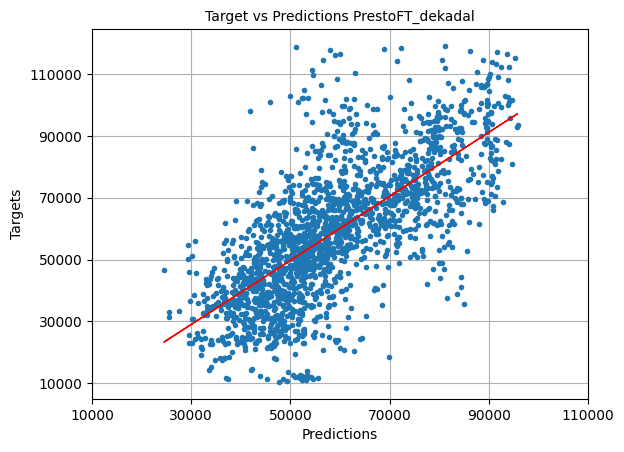

In [15]:
from scipy.stats import linregress
import matplotlib.pyplot as plt 

def predict(x):
    return slope * x + intercept

slope, intercept, r_value, p_value, std_err = linregress(preds, targets)
plt.figure()
plt.plot(preds, targets, 'o', markersize=3)
plt.plot(preds, predict(preds), 'r', linewidth=1)
plt.title(f'Target vs Predictions {model_name}', fontsize=10)
plt.ylabel('Targets')
plt.yticks(np.arange(min_val, max_val, 20000))
plt.xlabel('Predictions')
plt.xticks(np.arange(min_val, max_val, 20000))
plt.grid('on')